# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting "events of interest". You may choose between two data samples:
1. b-jets (sprays of particles with a b-quark in it) in Aleph Z -> qqbar MC (i.e. simulated decays of the Z0 boson decaying to a quark and an anti-quark).
2. A "medical" dataset regarding lifestyle diseases (reduced in size to match the Aleph b-jet data set).

In the following, we discuss the problem from the b-jet point of view, as this is where the largest size datasets are available. However, we stress that from the point of view of ML, data content (what is being considered) is not essential to know. And knowing this requires domain knowledge, i.e. that you are an expert in the specific field, that the data comes from. This part is very important, but not the focus in this course.

You are to make the selection in two ways:
* Initially, simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a Fisher discriminant (linear combination of input variables), which corresponds to a plane in the X-space. But as the problem is non-linear, it is likely to be sub-optimal.

* Next using Machine Learning (ML) methods. We will during the first week try both (Boosted) Decision Tree ((B)DT) based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

Once you obtain a classification of b-jets vs. non-b-jets, think about how to quantify the quality of your algorithm. Also, try to compare it to the NN result of the Aleph collaboration, given by the variable "nnbjet". It is based on a neural network with 6 input variables (prob_b, spheri, pt2rel, multip, bqvjet, and ptlrel), and two hidden layers each with 10 nodes in. Can you do better?

In the end, this exercise is the simple start "outside ML" and moving into the territory of Machine Learning analysis.


### Data:
The input variables (X) are (where Aleph uses only the first six):
* **prob_b**: Probability of being a b-jet from the pointing of the tracks to the vertex.
* **spheri**: Sphericity of the event, i.e. how spherical it is.
* **pt2rel**: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* **multip**: Multiplicity of the jet (in a relative measure).
* **bqvjet**: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* **ptlrel**: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).

The target variable (Y) is:
* isb:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):
* nnbjet: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).


### Task:
Thus, the task before you is to produce functions (non-ML and then ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we will discuss further. In classification problems (such as this), the typical loss function to use "Cross Entropy", see https://en.wikipedia.org/wiki/Cross_entropy.

Once you have results, you're welcome to continue with a Fisher Linear Discriminant, and you may also challenge yourself by considering "v1" of the data, which is a little less "polished and ready". If you also manage this, then don't hold back in applying a real ML algorithm to the problem (you can get inspiration from "ML_MethodsDemos.ipynb" or the vast internet). A suggestion might be XGBoost or LightGBM.

* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   17th of April 2024

In [65]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve
from optuna import Trial, create_study
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import shap
import pandas as pd

Possible other packages to consider:
cornerplot, seaplot, sklearn.decomposition(PCA)

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Evaluate an attempt at classification:

This is made into a function, as this is called many times. It returns a "confusion matrix" and the fraction of wrong classifications.

In [3]:
def evaluate(bquark) :
    N = [[0,0], [0,0]]   # Make a list of lists (i.e. confusion matrix) for counting successes/failures.
    for i in np.arange(len(isb)):
        if (bquark[i] == 0 and isb[i] == 0) : N[0][0] += 1
        if (bquark[i] == 0 and isb[i] == 1) : N[0][1] += 1
        if (bquark[i] == 1 and isb[i] == 0) : N[1][0] += 1
        if (bquark[i] == 1 and isb[i] == 1) : N[1][1] += 1
    fracWrong = float(N[0][1]+N[1][0])/float(len(isb))
    accuracy = 1.0 - fracWrong
    return N, accuracy, fracWrong

# Main program start:

Read in the data, and make arrays of each variable (and understand these!).

In [4]:
# Get data (with this very useful NumPy reader):
# data = np.genfromtxt('AlephBtag_MC_train_Nev5000.csv', names=True)    # For faster running
data = np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True)   # For more data

# Kinematics (energy and direction) of the jet:
energy = data['energy']
cTheta = data['cTheta']
phi    = data['phi']

# Classification variables (those used in Aleph's NN):
prob_b = data['prob_b']
spheri = data['spheri']
pt2rel = data['pt2rel']
multip = data['multip']
bqvjet = data['bqvjet']
ptlrel = data['ptlrel']

# Aleph's NN score:
nnbjet = data['nnbjet']

# Truth variable whether it really was a b-jet or not (i.e. target)
isb    = data['isb']

# Inspect the data:
Define the histogram range and binning (important - programs are generally NOT good at this):

In [5]:
Nbins = 100
xmin = 0.0
xmax = 1.0

### Make new lists selected based on what the jets really are (b-quark jet or light-quark jet):

In [6]:
prob_b_bjets = prob_b[isb == 1]
prob_b_ljets = prob_b[isb == 0]
bqvjet_bjets = bqvjet[isb == 1]
bqvjet_ljets = bqvjet[isb == 0]

### Produce 1D figures:

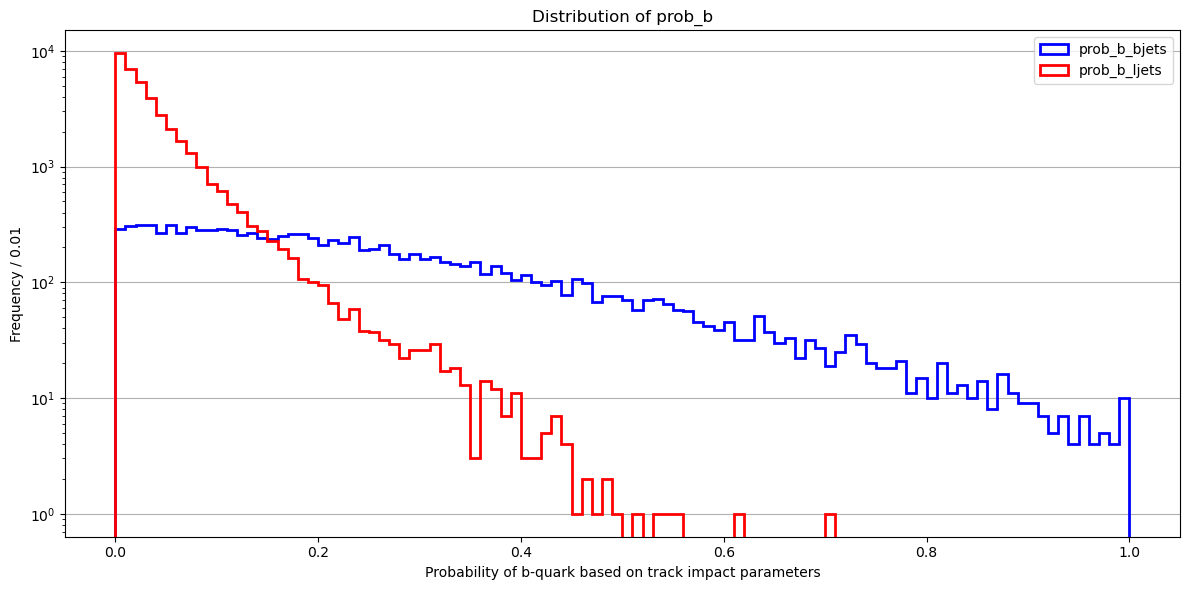

In [7]:
# Produce the actual figure, here with two histograms in it:
fig, ax = plt.subplots(figsize=(12, 6))      # Create just a single figure and axes (figsize is in inches!)
hist_prob_b_bjets = ax.hist(prob_b_bjets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_bjets', color='blue')
hist_prob_b_ljets = ax.hist(prob_b_ljets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_ljets', color='red')
ax.set_xlabel("Probability of b-quark based on track impact parameters")     # Label of x-axis
ax.set_ylabel("Frequency / 0.01")                                            # Label of y-axis
ax.set_title("Distribution of prob_b")                                       # Title of plot
ax.set_yscale("log")
ax.legend(loc='best')                                                        # Legend. Could also be 'upper right'
ax.grid(axis='y')

fig.tight_layout()

if SavePlots :
    fig.savefig('Hist_prob_b_and_bqvjet.pdf', dpi=600)

### Produce 2D figures:

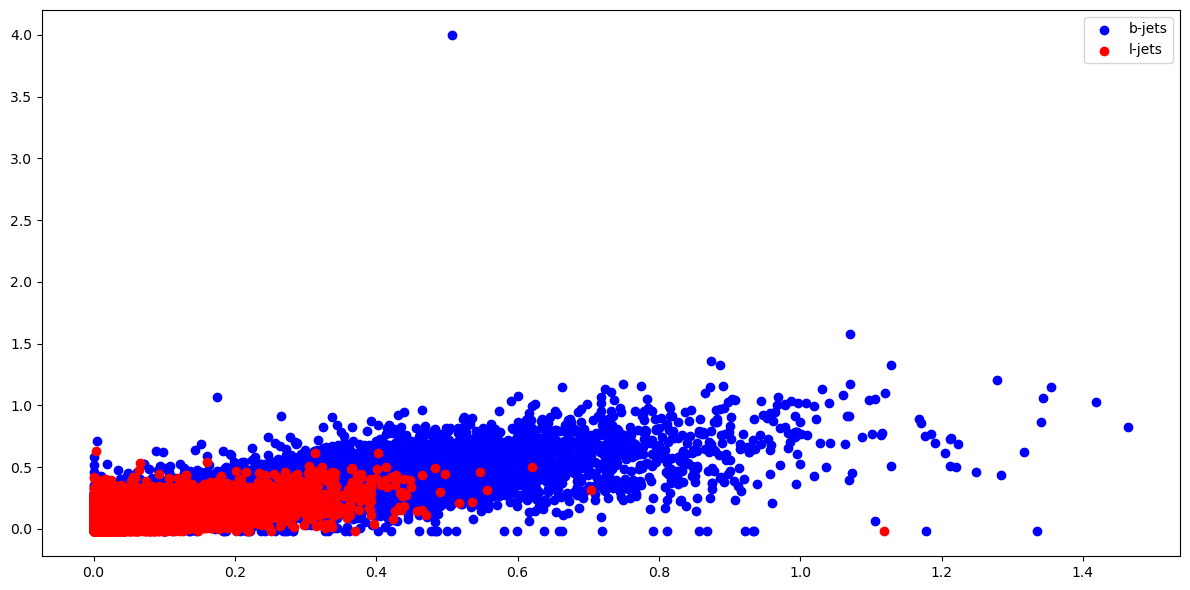

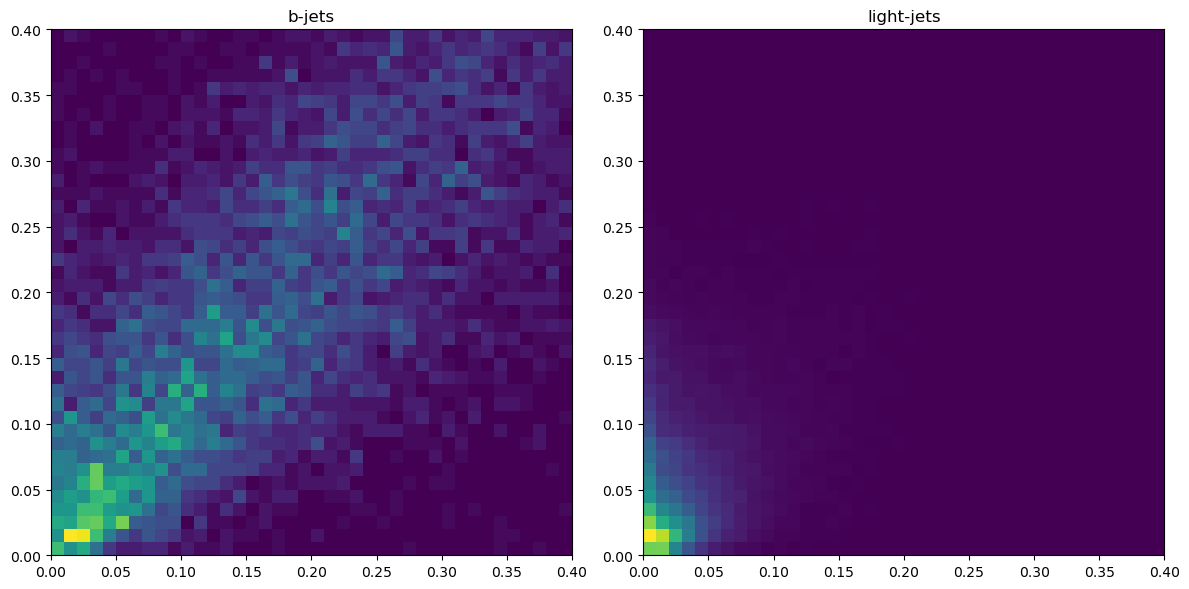

In [8]:
# First we try a scatter plot, to see how the individual events distribute themselves:
fig2, ax2 = plt.subplots(figsize=(12, 6))
scat2_prob_b_vs_bqvjet_bjets = ax2.scatter(prob_b_bjets, bqvjet_bjets, label='b-jets', color='blue')
scat2_prob_b_vs_bqvjet_ljets = ax2.scatter(prob_b_ljets, bqvjet_ljets, label='l-jets', color='red')
ax2.legend(loc='best')
fig2.tight_layout()

if SavePlots :
    fig2.savefig('Scatter_prob_b_vs_bqvjet.pdf', dpi=600)


# However, as can be seen in the figure, the overlap between b-jets and light-jets is large,
# and one covers much of the other in a scatter plot, which also does not show the amount of
# statistics in the dense regions. Therefore, we try two separate 2D histograms (zoomed):
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 6))
hist2_prob_b_vs_bqvjet_bjets = ax3[0].hist2d(prob_b_bjets, bqvjet_bjets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
hist2_prob_b_vs_bqvjet_ljets = ax3[1].hist2d(prob_b_ljets, bqvjet_ljets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
ax3[0].set_title("b-jets")
ax3[1].set_title("light-jets")

fig3.tight_layout()

if SavePlots :
    fig3.savefig('Hist2D_prob_b_vs_bqvjet.pdf', dpi=600)

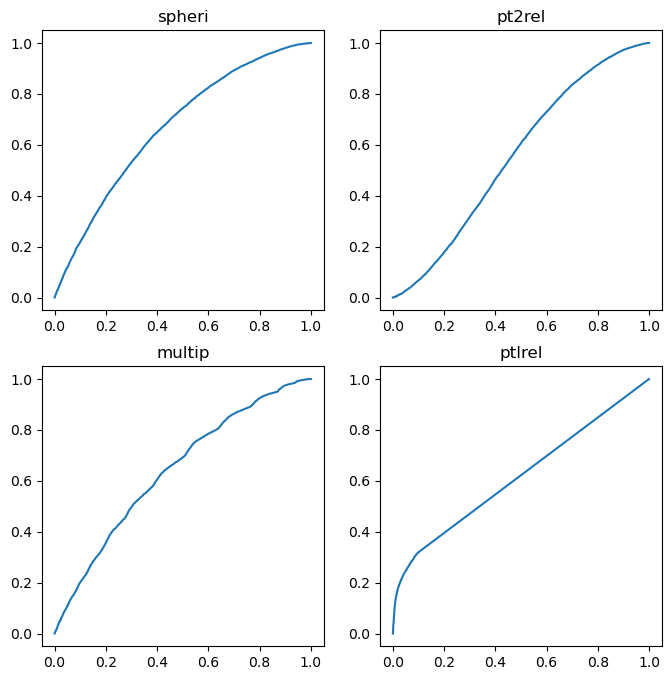

In [9]:
FPR_spheri, TPR_spheri, thresholds_spheri = roc_curve(isb, spheri)
FPR_pt2rel, TPR_pt2rel, thresholds_pt2rel = roc_curve(isb, pt2rel)
FPR_multip, TPR_multip, thresholds_multip = roc_curve(isb, multip)
FPR_ptlrel, TPR_ptlrel, thresholds_ptlrel = roc_curve(isb, ptlrel)

TPR_cut = 0.65
TPR_cut_tight = 0.85

spheri_cut = thresholds_spheri[TPR_spheri>=TPR_cut][0]
pt2rel_cut = thresholds_pt2rel[TPR_pt2rel>=TPR_cut][0]
multip_cut = thresholds_multip[TPR_multip>=TPR_cut][0]
ptlrel_cut = thresholds_ptlrel[TPR_ptlrel>=TPR_cut][0]

spheri_cut_tight = thresholds_spheri[TPR_spheri>=TPR_cut_tight][0]
pt2rel_cut_tight = thresholds_pt2rel[TPR_pt2rel>=TPR_cut_tight][0]
multip_cut_tight = thresholds_multip[TPR_multip>=TPR_cut_tight][0]
ptlrel_cut_tight = thresholds_ptlrel[TPR_ptlrel>=TPR_cut_tight][0]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].set_title("spheri")
axs[0,1].set_title("pt2rel")
axs[1,0].set_title("multip")
axs[1,1].set_title("ptlrel")
axs[0,0].plot(FPR_spheri, TPR_spheri)
axs[0,1].plot(FPR_pt2rel, TPR_pt2rel)
axs[1,0].plot(FPR_multip, TPR_multip)
axs[1,1].plot(FPR_ptlrel, TPR_ptlrel)

# Selection:

In [10]:
# I give the selection cuts names, so that they only need to be changed in ONE place (also ensures consistency!):
# Note: This is where you change things (selection values and adding variables) to improve the performance:
# cut_bqvjet = 0.20
cut_bqvjet = 0.1

# Think about how the above cuts "works", and then imagine what I have in mind below, trying to refine the selection:
cut_propb = 0.15
loose_propb = 0.07
tight_propb = 0.26
loose_bqvjet = 0.09
tight_bqvjet = 0.34

# If prob_b indicate b-quark, call it a b-quark, otherwise not!
bquark=[]
for i in np.arange(len(prob_b)):
    if (bqvjet[i] > cut_bqvjet) and (prob_b[i] > cut_propb):
        bquark.append(1)
    elif (bqvjet[i] > tight_bqvjet) or (prob_b[i] > tight_propb):
        bquark.append(1)
    else :
        bquark.append(0)
# for i in np.arange(len(prob_b)):
#     n_true = sum([
#         bqvjet[i] > cut_bqvjet,
#         prob_b[i] > cut_propb,
#         spheri[i] > spheri_cut,
#         pt2rel[i] > pt2rel_cut,
#         multip[i] > multip_cut,
#         ptlrel[i] > ptlrel_cut,
#     ])
#     n_true_tight = sum([
#         bqvjet[i] > tight_bqvjet,
#         prob_b[i] > tight_propb,
#         spheri[i] > spheri_cut_tight,
#         pt2rel[i] > pt2rel_cut_tight,
#         multip[i] > multip_cut_tight,
#         ptlrel[i] > ptlrel_cut_tight,
#     ])
#     n_tot = n_true + 2 * n_true_tight
#     if n_tot >= 10:
#         bquark.append(1)
#     else:
#         bquark.append(0)

### Evaluate the selection:

In [11]:
N, accuracy, fracWrong = evaluate(bquark)
print("\nRESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


RESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:
  First number in parenthesis is the estimate, second is the MC truth:
  True-Negative (0,0)  =  37634
  False-Negative (0,1) =  4364
  False-Positive (1,0) =  1176
  True-Positive (1,1)  =  6826
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.1108
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.8892


In [12]:
### Compare with Aleph NN-approach from 1990'ies:

In [12]:
bquark=[]
for i in np.arange(len(prob_b)):
    if   (nnbjet[i] > 0.82) : bquark.append(1)
    else : bquark.append(0)

N, accuracy, fracWrong = evaluate(bquark)
print("\nALEPH BJET TAG:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


ALEPH BJET TAG:
  First number in parenthesis is the estimate, second is the MC truth:
  True-Negative (0,0)  =  37459
  False-Negative (0,1) =  3494
  False-Positive (1,0) =  1351
  True-Positive (1,1)  =  7696
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.0969
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.9031


In [13]:
class XGBObjective:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def __call__(self, trial: Trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0, 1),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.2, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 20),
        }
        bst = XGBClassifier(**params)
        bst.fit(self.X_train, self.y_train)
        bst_pred = bst.predict(self.X_test)
        score = accuracy_score(self.y_test, bst_pred)
        return score


X = np.column_stack((prob_b, spheri, pt2rel, multip, bqvjet, ptlrel))
X_train, X_test, y_train, y_test = train_test_split(
    X, isb, test_size=0.2, random_state=42
)
objective = XGBObjective(X_train, X_test, y_train, y_test)
study = create_study(direction="maximize")
study.optimize(objective, n_trials=100)
best_trial = study.best_trial
optimal_params = best_trial.params

bst = XGBClassifier(**optimal_params)
bst.fit(X_train, y_train)
pred_train = bst.predict(X_train)
pred_test = bst.predict(X_test)

[I 2024-05-01 10:36:21,397] A new study created in memory with name: no-name-f5c24e92-764c-40b0-a1cd-56b1ee0cbc47


[I 2024-05-01 10:36:22,435] Trial 0 finished with value: 0.9016 and parameters: {'n_estimators': 453, 'learning_rate': 0.40084552524058825, 'max_depth': 5, 'lambda': 0.45167289285744666, 'alpha': 2.235659508662282e-05, 'subsample': 0.9186468146521289, 'colsample_bytree': 0.7291689121837606, 'gamma': 8.48124592777896}. Best is trial 0 with value: 0.9016.
[I 2024-05-01 10:36:23,949] Trial 1 finished with value: 0.8996 and parameters: {'n_estimators': 709, 'learning_rate': 0.719865673262551, 'max_depth': 3, 'lambda': 0.006769667462105215, 'alpha': 8.102270886232886e-08, 'subsample': 0.9806134581748744, 'colsample_bytree': 0.8492658976725302, 'gamma': 1.412804885699539}. Best is trial 0 with value: 0.9016.
[I 2024-05-01 10:36:24,476] Trial 2 finished with value: 0.9034 and parameters: {'n_estimators': 844, 'learning_rate': 0.48125941556111673, 'max_depth': 7, 'lambda': 7.5337978541771585e-06, 'alpha': 0.006136203414723851, 'subsample': 0.7616616465060677, 'colsample_bytree': 0.494197814384

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
frac_wrong_xgb = (fn + fp) / (tn + fp + fn + tp)
frac_right_xgb = (tn + tp) / (tn + fp + fn + tp)
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", frac_wrong_xgb)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", frac_right_xgb)

    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.095
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.905


### Grid search

In [28]:
parameters_GridSearch = {
    "max_depth": np.arange(1, 10, 2),
    "n_estimators": np.arange(100, 1000, 200),
    "learning_rate": np.linspace(0, 1, 5),
}
GridSearch = GridSearchCV(
    XGBClassifier(),
    parameters_GridSearch,
    verbose=3,
    cv=5,
    return_train_score=True,
    refit=True,
)

In [29]:
GridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5] END learning_rate=0.0, max_depth=1, n_estimators=100;, score=(train=0.774, test=0.774) total time=   0.3s
[CV 2/5] END learning_rate=0.0, max_depth=1, n_estimators=100;, score=(train=0.774, test=0.774) total time=   0.1s
[CV 3/5] END learning_rate=0.0, max_depth=1, n_estimators=100;, score=(train=0.774, test=0.774) total time=   0.4s
[CV 4/5] END learning_rate=0.0, max_depth=1, n_estimators=100;, score=(train=0.774, test=0.774) total time=   0.1s
[CV 5/5] END learning_rate=0.0, max_depth=1, n_estimators=100;, score=(train=0.774, test=0.774) total time=   0.3s
[CV 1/5] END learning_rate=0.0, max_depth=1, n_estimators=300;, score=(train=0.774, test=0.774) total time=   0.3s
[CV 2/5] END learning_rate=0.0, max_depth=1, n_estimators=300;, score=(train=0.774, test=0.774) total time=   0.4s
[CV 3/5] END learning_rate=0.0, max_depth=1, n_estimators=300;, score=(train=0.774, test=0.774) total time=   0.2s
[CV 4/5] END lear

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                         'max_depth': array([1, 3, 5, 7, 9]),
                         'n_estimators': array([100, 300, 500, 700, 900])},
             return_train_score=True, verbose=3)

In [44]:
from scipy.stats import randint, uniform
GridSearch_results = pd.DataFrame(GridSearch.cv_results_)
print("Grid Search: \tBest parameters: ", GridSearch.best_params_, f", Best scores: {GridSearch.best_score_:.4f}\n")

Grid Search: 	Best parameters:  {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100} , Best scores: 0.9043



### Random search

In [45]:
parameters_RandomSearch = {
    "max_depth": randint(1, 10),
    "n_estimators": randint(100, 1000),
    "learning_rate": uniform(0, 1),
}

In [46]:
n_iter = 125
RandomSearch = RandomizedSearchCV(
    XGBClassifier(),
    param_distributions=parameters_RandomSearch,
    n_iter=n_iter,
    cv=5,
    return_train_score=True,
    random_state=42,
    verbose=3
)

In [47]:
RandomSearch.fit(X_train, y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5] END learning_rate=0.3745401188473625, max_depth=8, n_estimators=800;, score=(train=1.000, test=0.891) total time=   3.1s
[CV 2/5] END learning_rate=0.3745401188473625, max_depth=8, n_estimators=800;, score=(train=1.000, test=0.892) total time=   2.1s
[CV 3/5] END learning_rate=0.3745401188473625, max_depth=8, n_estimators=800;, score=(train=1.000, test=0.892) total time=   2.2s
[CV 4/5] END learning_rate=0.3745401188473625, max_depth=8, n_estimators=800;, score=(train=1.000, test=0.893) total time=   1.5s
[CV 5/5] END learning_rate=0.3745401188473625, max_depth=8, n_estimators=800;, score=(train=1.000, test=0.896) total time=   1.4s
[CV 1/5] END learning_rate=0.596850157946487, max_depth=3, n_estimators=314;, score=(train=0.930, test=0.897) total time=   0.2s
[CV 2/5] END learning_rate=0.596850157946487, max_depth=3, n_estimators=314;, score=(train=0.929, test=0.901) total time=   0.2s
[CV 3/5] END learning_rate=0.

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   n_iter=125,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f945f06e210>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f945e54eb50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f945f0c8410>},
                   random_state=42, return_train_score=True, verbose=3)

In [39]:
RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0} , Best scores: 0.774


### Regression
We now try to do regression instead of classification, we try to predict |ctheta|.

In [15]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

class XGBObjectiveRegression:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def __call__(self, trial: Trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0, 1),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.2, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 20),
        }
        bst = XGBRegressor(**params)
        bst.fit(self.X_train, self.y_train)
        bst_pred = bst.predict(self.X_test)
        score = mean_squared_error(self.y_test, bst_pred)
        return score

In [16]:
X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(
    X, abs(cTheta), test_size=0.2, random_state=42
)
objective_regr = XGBObjectiveRegression(X_train, X_test, y_train, y_test)
study_regr = create_study(direction="minimize")
study_regr.optimize(objective_regr, n_trials=100)
best_trial_regr = study_regr.best_trial
optimal_params_regr = best_trial_regr.params
study_regr_best_val = study_regr.best_value

[I 2024-05-01 10:40:12,505] A new study created in memory with name: no-name-5118e8fb-0440-40fd-a85a-34f5b0bf745a


[I 2024-05-01 10:40:13,689] Trial 0 finished with value: 0.07734017196012312 and parameters: {'n_estimators': 797, 'learning_rate': 0.8316970377827753, 'max_depth': 10, 'lambda': 0.003131973014824639, 'alpha': 0.2398669776682624, 'subsample': 0.23243344004002378, 'colsample_bytree': 0.2932937740745569, 'gamma': 2.5254219916478315}. Best is trial 0 with value: 0.07734017196012312.
[I 2024-05-01 10:40:13,924] Trial 1 finished with value: 0.0762618534455117 and parameters: {'n_estimators': 333, 'learning_rate': 0.3126521086017535, 'max_depth': 3, 'lambda': 1.0080712051479362e-08, 'alpha': 0.19989180598545228, 'subsample': 0.6600698406839643, 'colsample_bytree': 0.9856346438868462, 'gamma': 11.311711595767168}. Best is trial 1 with value: 0.0762618534455117.
[I 2024-05-01 10:40:14,622] Trial 2 finished with value: 0.1667056799550289 and parameters: {'n_estimators': 452, 'learning_rate': 8.71293324929967e-05, 'max_depth': 4, 'lambda': 8.770436014111396e-06, 'alpha': 0.24656476833427607, 'su

In [17]:
print(
    f"Regression XGB best params: {optimal_params_regr}\n",
    f"Minimum mean squared error: {study_regr_best_val}"
)

Regression XGB best params: {'n_estimators': 703, 'learning_rate': 0.01890264316080507, 'max_depth': 7, 'lambda': 0.003340832033163962, 'alpha': 0.010947662870759272, 'subsample': 0.6358452051873849, 'colsample_bytree': 0.9972623589888796, 'gamma': 1.0013741154269873}
 Minimum mean squared error: 0.0719339909475713


### Feature importance

Let us try to look at feature importances for our XGBoost model.

We start with the built-in XGBoost feature importance measures, then we move on to permutation importance and then to SHAP.

In [40]:
fi_gain = np.array(list(bst.get_booster().get_score(importance_type="gain").values()))
fi_weight = np.array(
    list(bst.get_booster().get_score(importance_type="weight").values())
)
fi_cover = np.array(list(bst.get_booster().get_score(importance_type="cover").values()))

fi_gain_sort_id = np.argsort(fi_gain)
fi_weight_sort_id = np.argsort(fi_weight)
fi_cover_sort_id = np.argsort(fi_cover)

feature_names = np.array(["prob_b", "spheri", "pt2rel", "multip", "bqvjet", "ptlrel"])

Text(0.5, 0, 'Gain feature importance')

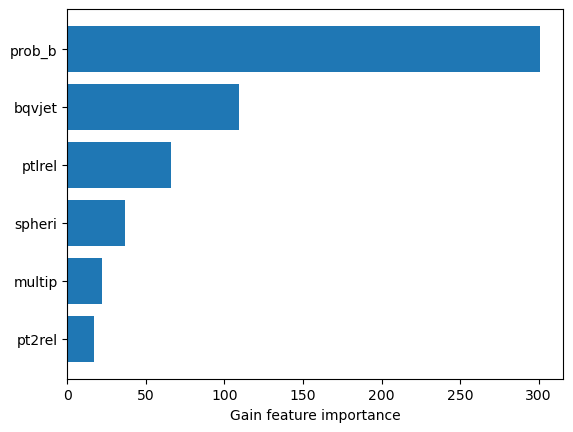

In [42]:
plt.barh(feature_names[fi_gain_sort_id], fi_gain[fi_gain_sort_id])
plt.xlabel("Gain feature importance")

Text(0.5, 0, 'Weight feature importance')

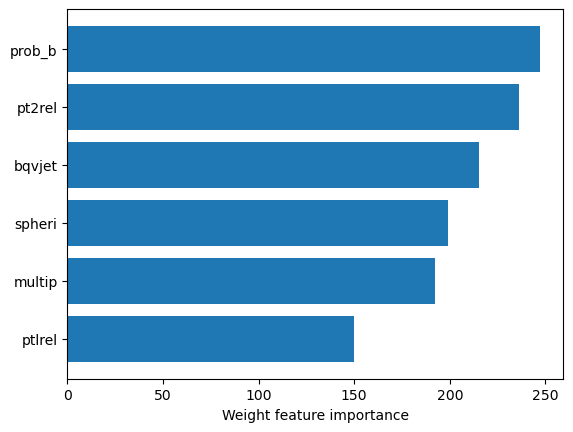

In [43]:
plt.barh(feature_names[fi_weight_sort_id], fi_weight[fi_weight_sort_id])
plt.xlabel("Weight feature importance")

Text(0.5, 0, 'Cover feature importance')

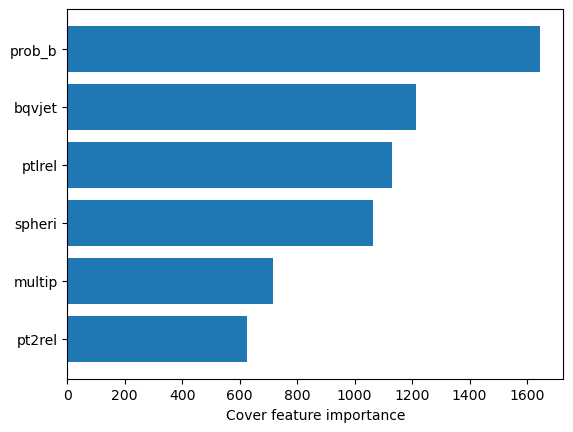

In [44]:
plt.barh(feature_names[fi_cover_sort_id], fi_cover[fi_cover_sort_id])
plt.xlabel("Cover feature importance")

In [50]:
from sklearn.inspection import permutation_importance
fi_permut = permutation_importance(bst, X_test, y_test, n_repeats=30)
fi_permut_mean = fi_permut.importances_mean
fi_permut_std = fi_permut.importances_std
fi_permut_sort_id = np.argsort(fi_permut_mean)

Text(0.5, 0, 'Permutation feature importance')

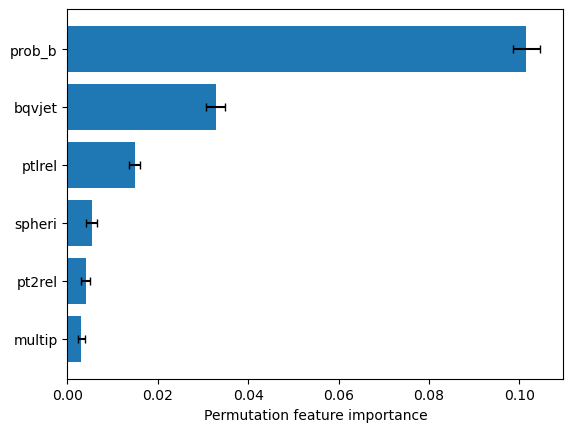

In [59]:
plt.barh(feature_names[fi_permut_sort_id], fi_permut_mean[fi_permut_sort_id], xerr=fi_permut_std[fi_permut_sort_id], capsize=3)
plt.xlabel("Permutation feature importance")

In [63]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)
shap_values

array([[-0.2644806 , -0.2681266 , -0.39008182,  0.00993888, -0.8430339 ,
        -0.24013177],
       [-1.6659955 , -0.15155546,  0.11848865,  0.0564477 , -0.70634484,
        -0.20740694],
       [ 0.08950523, -0.00788821,  0.24060528, -0.18637158, -0.30696374,
         0.33042768],
       ...,
       [ 0.18967322, -0.3124711 ,  0.27459162, -0.2649959 , -0.6884882 ,
        -0.2523346 ],
       [ 0.25445783,  0.0818304 , -0.28957567, -0.10110256, -0.5082192 ,
        -0.20896623],
       [-1.1618826 ,  0.5450906 ,  0.02270976, -0.33514363, -0.6901033 ,
        -0.24456584]], dtype=float32)

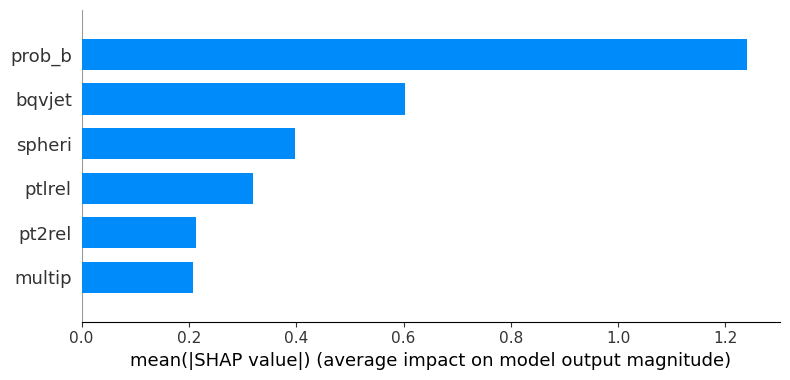

In [66]:
shap.summary_plot(shap_values, pd.DataFrame(X_test, columns=feature_names), plot_type="bar")

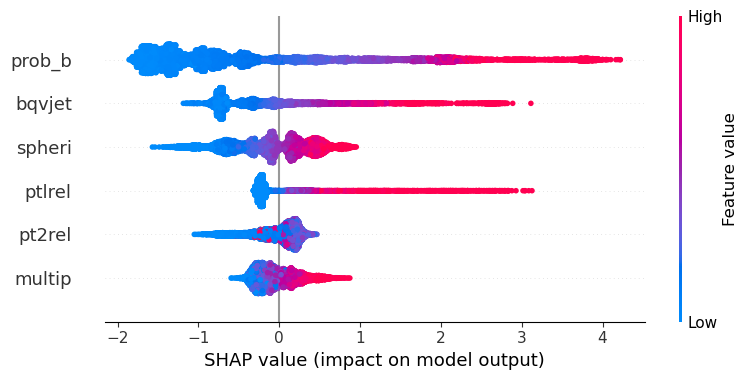

In [71]:
shap.summary_plot(shap_values, pd.DataFrame(X_test, columns=feature_names))

# Suggested problems:

1. Start by plotting the six "Aleph classification variables" for signal and background, and see which seems to separate most. Possibly draw ROC curves for all of these separately, to quantify this.

2. As you can see, the Aleph-NN performs significantly better. Try to optimize your cuts, combining several of them in smart ways. You may also want to make a linear combination (i.e. Fisher Linear Discriminant) to do better. Challenge yourself to push it as far as you can (well, for say 30 minutes).

3. Does including more data (50000 instead of 5000 events) help your performance?

4. Currently, the scoring (also called the loss function) is simply done by considering the fraction of wrong estimates. Think about what the alternatives could be, especially if you were to give a continuous score like the Aleph-NN.

# Learning points:

From this exercise you should get a feel for the problem at hand, namely how to separate two populations in a 6-dimensional space. It is hard to imagine, yet with simple cuts you should be able to get "some performance", though never anywhere close to the Aleph-NN. You should learn, that it is hard, but that at least the fact that you have known cases makes you capable of getting that "some performance". And you should of course be able to draw ROC curves to compare performances.

The next steps (i.e. following exercises) are to improve this performance through the use of Machine Learning (ML), and make you capable not only of getting results, but also confident in optimising them, and certainly proficient in interpreting them.